# Linear Modeling Case Study

This script contains a machine learning model that predicts the number of bikes rentals started at a given hour for the Chicago Cook County Planning and Development Department.

I employed data analytics and machine learning techniques to predict the number of bike rentals given a set of explanatory variables. It was evident that the 2 most important factors for predicting rentals were the hour of day and the weather conditions (specifically temperature and humidity).

The store was not functioning during some hours so rentals would be 0. Delegating this task to a simple algorithm rather than trusting the machine learning algorithms to discover this relationship helped to improve accuracy significantly.

I imported all data, filled missing values, applied transformations, visualized the data, developed multiple models, and tuned the hyper parameters using GridSearchCV. The final model had an r-square of about 0.80 which means we can explain about 80% of the variations in the data.

## Imports and Data Checks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# draw plots inlint
%matplotlib inline 

plt.style.use(style = 'seaborn-v0_8') # set plot styles

# set pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# load data from excel
train_df = pd.read_excel(io = './datasets/train.xlsx')
test_df = pd.read_excel(io = './datasets/test.xlsx')

# separate Kaggle data
train_df['Is_Kaggle'] = True
test_df ['Is_Kaggle'] = False

merged_df = pd.concat([train_df, test_df], axis=0, ignore_index=True) # merge data frames

y_variable = 'RENTALS'
LOG_PREFIX = 'Log_'
INV_PREFIX = 'Inv_'
log_y_variable = LOG_PREFIX + y_variable
inv_y_variable = INV_PREFIX + y_variable # variable to predict

In [3]:
merged_df.head() # check merged data frame

ID                    DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2) Holiday FunctioningDay  RENTALS  Is_Kaggle
0  mb_1039  2023-10-14 05:59:54.810000              52           81               0.4                2.9                    46.4           0.0           0.0                   0.00      No            Yes    519.0       True
1  mb_1330  2023-10-26 08:59:53.355000              51           53               2.2                NaN                    35.2           0.0           0.0                   1.01      No            Yes   1251.0       True
2   mb_551  2023-09-23 21:59:57.250000              56           49               2.5                3.4                    38.8           0.0           0.0                   0.00      No            Yes   1685.0       True
3  mb_2103         2023-12-19 14:00:00              69           32               9.8               12.4                    38.7           0.0           0.0                   2.36      No             No      0.0       True
4  mb_1430  2023-10-30 12:59:52.855000              53           20               2.9               10.8                    12.9           0.0           0.0                   1.96      No            Yes    814.0       True

In [4]:
train_df.head() # check train

ID                    DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2) Holiday FunctioningDay  RENTALS  Is_Kaggle
0  mb_1039  2023-10-14 05:59:54.810000              52           81               0.4                2.9                    46.4           0.0           0.0                   0.00      No            Yes      519       True
1  mb_1330  2023-10-26 08:59:53.355000              51           53               2.2                NaN                    35.2           0.0           0.0                   1.01      No            Yes     1251       True
2   mb_551  2023-09-23 21:59:57.250000              56           49               2.5                3.4                    38.8           0.0           0.0                   0.00      No            Yes     1685       True
3  mb_2103         2023-12-19 14:00:00              69           32               9.8               12.4                    38.7           0.0           0.0                   2.36      No             No        0       True
4  mb_1430  2023-10-30 12:59:52.855000              53           20               2.9               10.8                    12.9           0.0           0.0                   1.96      No            Yes      814       True

In [5]:
test_df.head() # check test

ID                    DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2) Holiday FunctioningDay  Is_Kaggle
0  mb_382  2023-09-16 20:59:58.095000              73           70               5.6                9.8                    65.7           0.0           0.0                   0.00      No            Yes      False
1  mb_547  2023-09-23 17:59:57.270000              63           39               2.2                2.5                    39.0           0.0           0.0                   0.21      No            Yes      False
2  mb_578  2023-09-25 00:59:57.115000              69           54               0.2                8.6                    48.6           0.0           0.0                   0.00      No            Yes      False
3  mb_187  2023-09-08 17:59:59.070000              69           43               4.0                6.2                    46.9           0.0           0.0                   0.26     Yes            Yes      False
4  mb_227  2023-09-10 09:59:58.870000              75           73               6.9               12.3                    64.2           0.0           0.0                   2.28      No            Yes      False

## Data Preparation

### Handle missing values

In [6]:
merged_df.isna().sum() # check missing values

ID                          0
DateHour                    0
Temperature(F)              0
Humidity(%)                 0
Wind speed (mph)            0
Visibility(miles)          76
DewPointTemperature(F)     67
Rainfall(in)                0
Snowfall(in)                0
SolarRadiation(MJ/m2)     106
Holiday                     0
FunctioningDay              0
RENTALS                   546
Is_Kaggle                   0
dtype: int64

#### <i>Finding:</i>

- ```Visibility(miles)```, ```DewPointTemperature(F)```, and ```SolarRadiation(MJ/m2)``` have missing values. They are all continuous variables so we can easily impute a central tendency. We can refine our approach by using KNNImputer to impute the most likely value based on similar data points.

In [7]:
# remove numeric missing values
numeric_columns = merged_df.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop('RENTALS') # no need to impute rentals
numeric_merged_df = merged_df[numeric_columns]

imputer = KNNImputer(n_neighbors=12, weights='uniform', metric='nan_euclidean')
filled_merged_df = pd.DataFrame(imputer.fit_transform(numeric_merged_df), columns=numeric_columns) # impute

merged_df[numeric_columns] = filled_merged_df[numeric_columns]

merged_df.isna().sum() # check data frame again

ID                          0
DateHour                    0
Temperature(F)              0
Humidity(%)                 0
Wind speed (mph)            0
Visibility(miles)           0
DewPointTemperature(F)      0
Rainfall(in)                0
Snowfall(in)                0
SolarRadiation(MJ/m2)       0
Holiday                     0
FunctioningDay              0
RENTALS                   546
Is_Kaggle                   0
dtype: int64

#### *Finding:*

- No more missing data

### Handle Data Types

In [8]:
merged_df.info() # check data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2184 non-null   object 
 1   DateHour                2184 non-null   object 
 2   Temperature(F)          2184 non-null   float64
 3   Humidity(%)             2184 non-null   float64
 4   Wind speed (mph)        2184 non-null   float64
 5   Visibility(miles)       2184 non-null   float64
 6   DewPointTemperature(F)  2184 non-null   float64
 7   Rainfall(in)            2184 non-null   float64
 8   Snowfall(in)            2184 non-null   float64
 9   SolarRadiation(MJ/m2)   2184 non-null   float64
 10  Holiday                 2184 non-null   object 
 11  FunctioningDay          2184 non-null   object 
 12  RENTALS                 1638 non-null   float64
 13  Is_Kaggle               2184 non-null   bool   
dtypes: bool(1), float64(9), object(4)
memory

#### <i>Finding:</i>

- ```DateHour``` can be Python datetime object
- ```Holiday``` and ```FunctioningDay``` can be int (0 and 1)

In [9]:
# convert DateHour to datetime object
merged_df['DateHour'] = pd.to_datetime(
    merged_df['DateHour'],
    format = 'ISO8601'
)

# convert Holiday and FunctioningDay to int
merged_df['Holiday'] = merged_df['Holiday'].map({'Yes': 1, 'No': 0})
merged_df['FunctioningDay'] = merged_df['FunctioningDay'].map({'Yes': 1, 'No': 0})

In [10]:
merged_df.info() # check again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      2184 non-null   object        
 1   DateHour                2184 non-null   datetime64[ns]
 2   Temperature(F)          2184 non-null   float64       
 3   Humidity(%)             2184 non-null   float64       
 4   Wind speed (mph)        2184 non-null   float64       
 5   Visibility(miles)       2184 non-null   float64       
 6   DewPointTemperature(F)  2184 non-null   float64       
 7   Rainfall(in)            2184 non-null   float64       
 8   Snowfall(in)            2184 non-null   float64       
 9   SolarRadiation(MJ/m2)   2184 non-null   float64       
 10  Holiday                 2184 non-null   int64         
 11  FunctioningDay          2184 non-null   int64         
 12  RENTALS                 1638 non-null   float64 

#### *Finding:*

Data looks fine and perfect now.

### Transformations

I applied log and inverse transformation to all columns.

In [11]:
# create log and inverse transformation for all numeric columns
numeric_columns = merged_df.select_dtypes(include='number').columns

for column in numeric_columns:
    merged_df[LOG_PREFIX + column] = merged_df[column].apply(lambda x: np.log1p(x) if x > -1 else 0)
    merged_df[INV_PREFIX + column] = merged_df[column].apply(lambda x: 1 / (x + 1))


In [12]:
merged_df.head() # check it

ID                DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2)  Holiday  FunctioningDay  RENTALS  Is_Kaggle  Log_Temperature(F)  Inv_Temperature(F)  Log_Humidity(%)  Inv_Humidity(%)  Log_Wind speed (mph)  Inv_Wind speed (mph)  Log_Visibility(miles)  Inv_Visibility(miles)  Log_DewPointTemperature(F)  Inv_DewPointTemperature(F)  Log_Rainfall(in)  Inv_Rainfall(in)  Log_Snowfall(in)  Inv_Snowfall(in)  Log_SolarRadiation(MJ/m2)  Inv_SolarRadiation(MJ/m2)  Log_Holiday  Inv_Holiday  Log_FunctioningDay  Inv_FunctioningDay  Log_RENTALS  Inv_RENTALS
0  mb_1039 2023-10-14 05:59:54.810            52.0         81.0               0.4           2.900000                    46.4           0.0           0.0                   0.00        0               1    519.0       True            3.970292            0.018868         4.406719         0.012195              0.336472              0.714286               1.360977               0.256410                    3.858622                    0.021097               0.0               1.0               0.0               1.0                   0.000000                   1.000000          0.0          1.0            0.693147                 0.5     6.253829     0.001923
1  mb_1330 2023-10-26 08:59:53.355            51.0         53.0               2.2           8.966667                    35.2           0.0           0.0                   1.01        0               1   1251.0       True            3.951244            0.019231         3.988984         0.018519              1.163151              0.312500               2.299246               0.100334                    3.589059                    0.027624               0.0               1.0               0.0               1.0                   0.698135                   0.497512          0.0          1.0            0.693147                 0.5     7.132498     0.000799
2   mb_551 2023-09-23 21:59:57.250            56.0         49.0               2.5           3.400000                    38.8           0.0           0.0                   0.00        0               1   1685.0       True            4.043051            0.017544         3.912023         0.020000              1.252763              0.285714               1.481605               0.227273                    3.683867                    0.025126               0.0               1.0               0.0               1.0                   0.000000                   1.000000          0.0          1.0            0.693147                 0.5     7.430114     0.000593
3  mb_2103 2023-12-19 14:00:00.000            69.0         32.0               9.8          12.400000                    38.7           0.0           0.0                   2.36        0               0      0.0       True            4.248495            0.014286         3.496508         0.030303              2.379546              0.092593               2.595255               0.074627                    3.681351                    0.025189               0.0               1.0               0.0               1.0                   1.211941                   0.297619          0.0          1.0            0.000000                 1.0     0.000000     1.000000
4  mb_1430 2023-10-30 12:59:52.855            53.0         20.0               2.9          10.800000                    12.9           0.0           0.0                   1.96        0               1    814.0       True            3.988984            0.018519         3.044522         0.047619              1.360977              0.256410               2.468100               0.084746                    2.631889                    0.071942               0.0               1.0               0.0               1.0                   1.085189                   0.337838          0.0          1.0            0.693147                 0.5     6.703188     0.001227

### Exploratory Data Analysis (EDA)

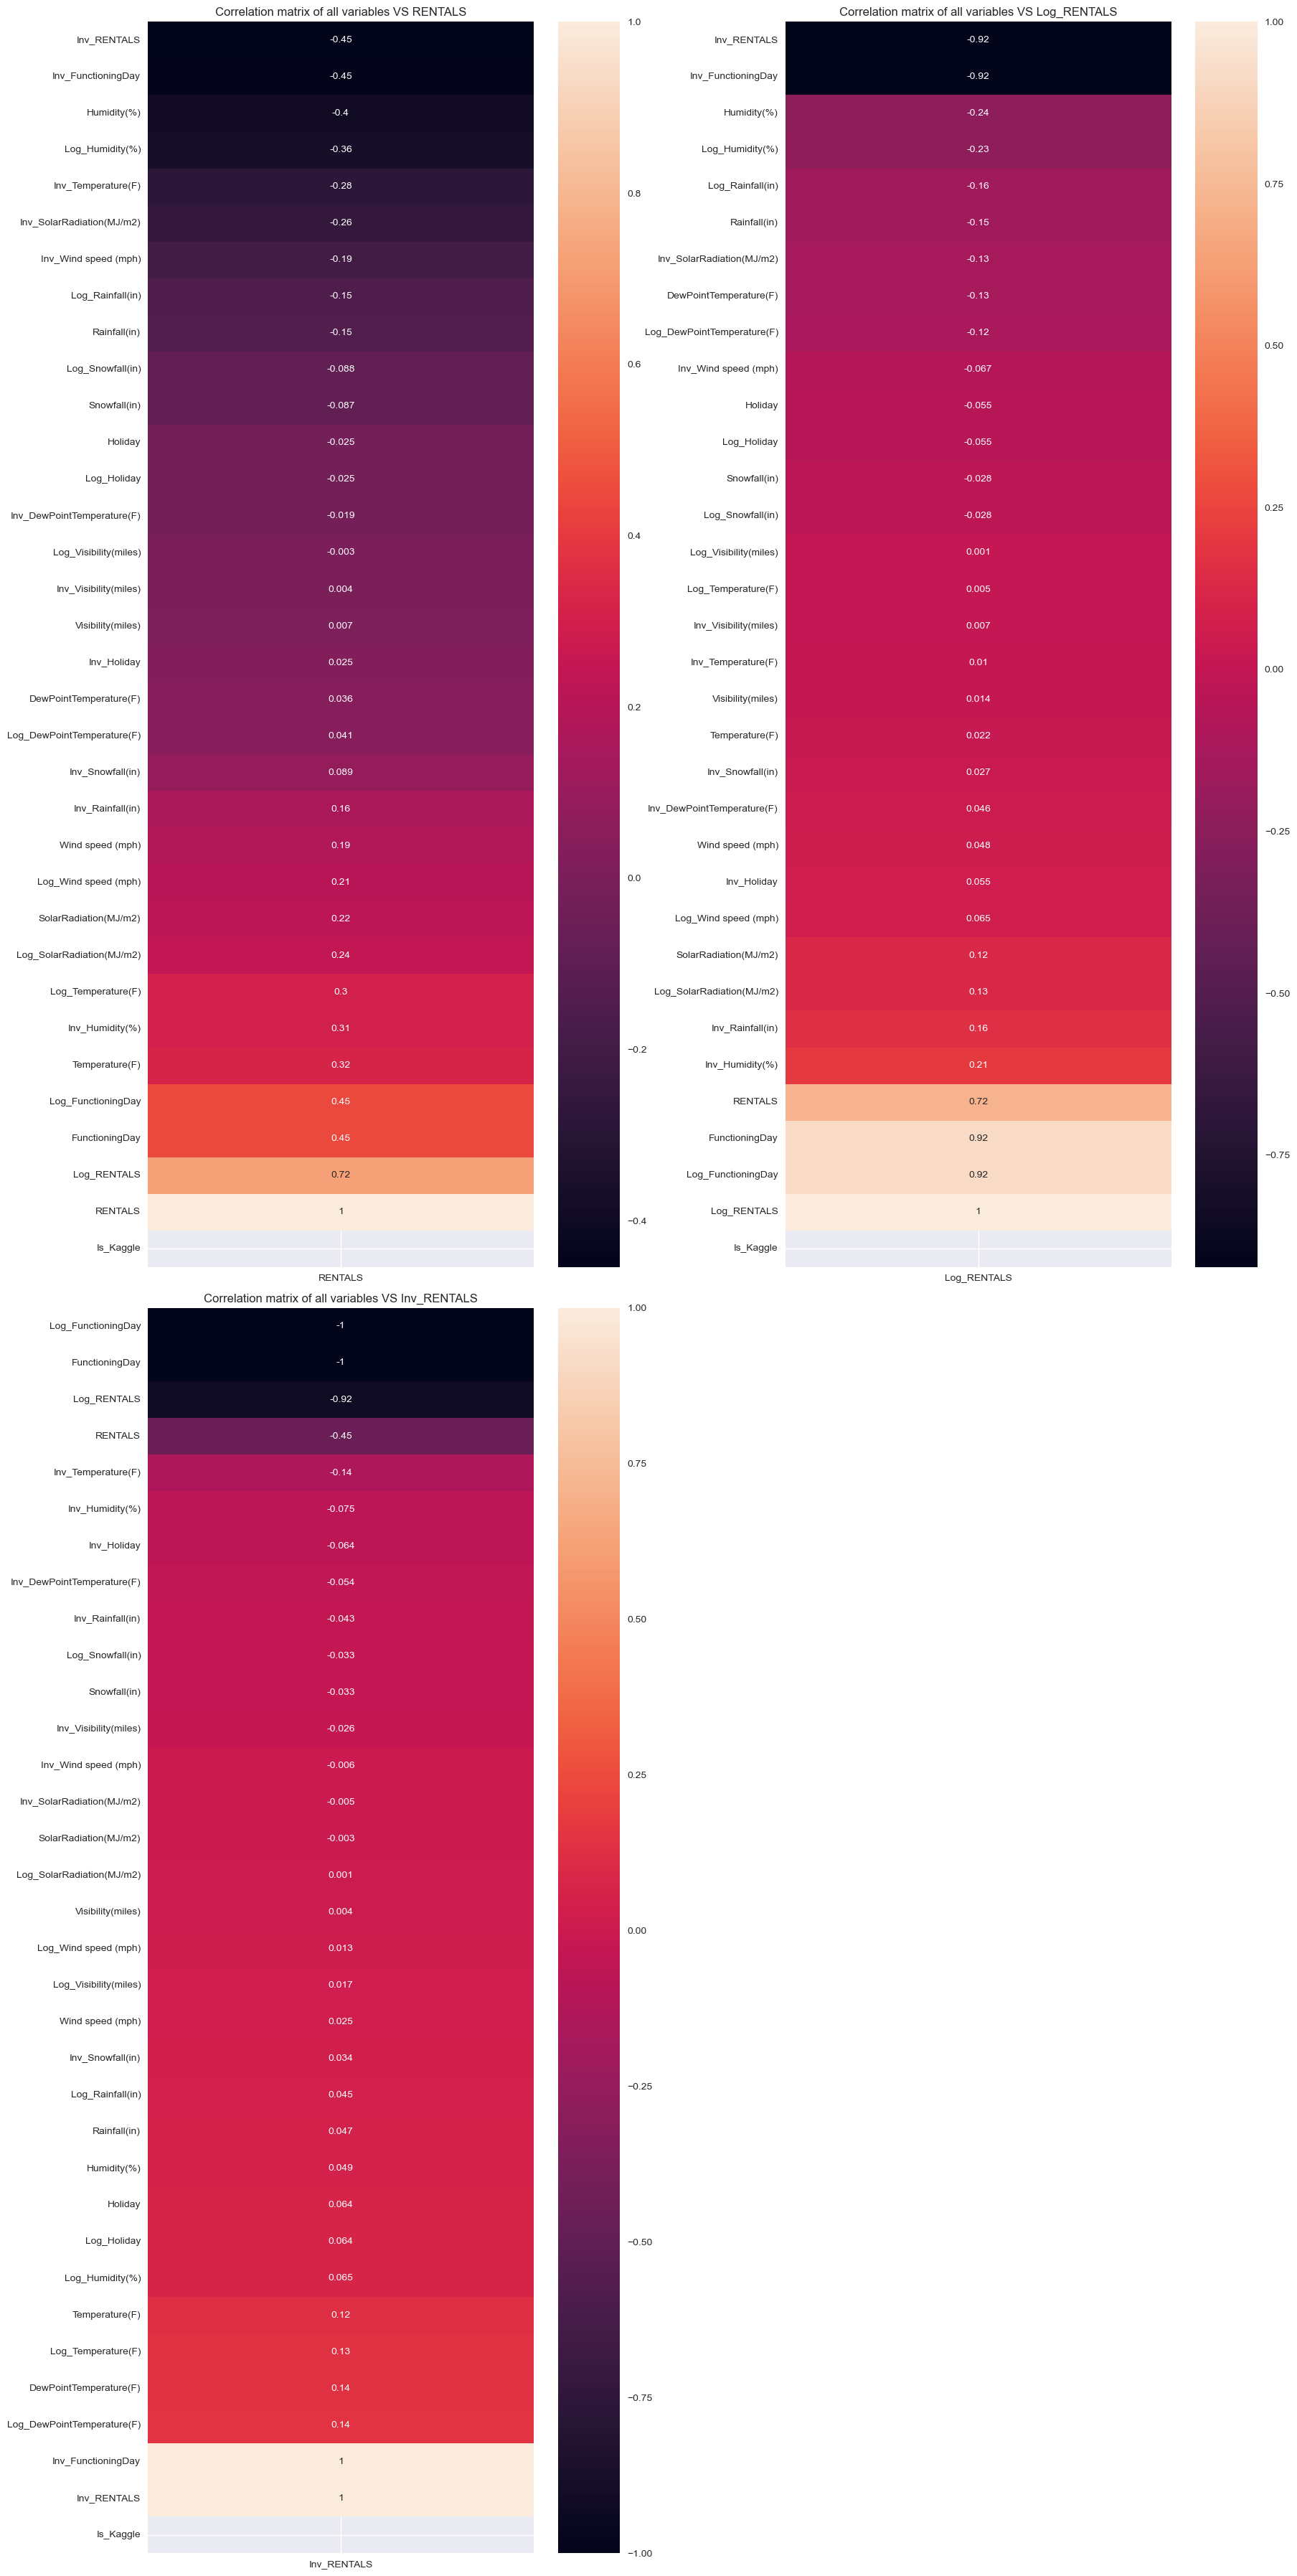

In [13]:
# draw correlation matrix with y_variable and transformations
no_na_merged_df = merged_df.dropna() # remove non-na data

# get sorted correlations of non-na data
corr = no_na_merged_df.corr(numeric_only = True).round(3)[[y_variable]].sort_values(y_variable)
corr_log = no_na_merged_df.corr(numeric_only = True).round(3)[[log_y_variable]].sort_values(log_y_variable)
corr_inv = no_na_merged_df.corr(numeric_only = True).round(3)[[inv_y_variable]].sort_values(inv_y_variable)

base_text = 'Correlation matrix of all variables VS'

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 36))

ax[0,0].set_title(f'{base_text} {y_variable}')
sns.heatmap(corr, annot=True, ax=ax[0,0])

ax[0,1].set_title(f'{base_text} {log_y_variable}')
sns.heatmap(corr_log, annot=True, ax=ax[0,1])

ax[1,0].set_title(f'{base_text} {inv_y_variable}')
sns.heatmap(corr_inv, annot=True, ax=ax[1,0])

ax[1,1].axis('off') # empty last axis

plt.tight_layout()
plt.show()

#### *Findings:*

- The 3 correlation matrixes show us the correletion of all variables and their transformation with one another.
- ```Humidity```, ```Temperature```, ```FunctioningDay``` have a strong correlation with rentals.
- The log and inverse transformation of rentals do not really add any value, as correlations generally performed better on the original.
- Functioning Day's impact is very evident with the inverse function.
- Some factors one would think have a high correlations do not.

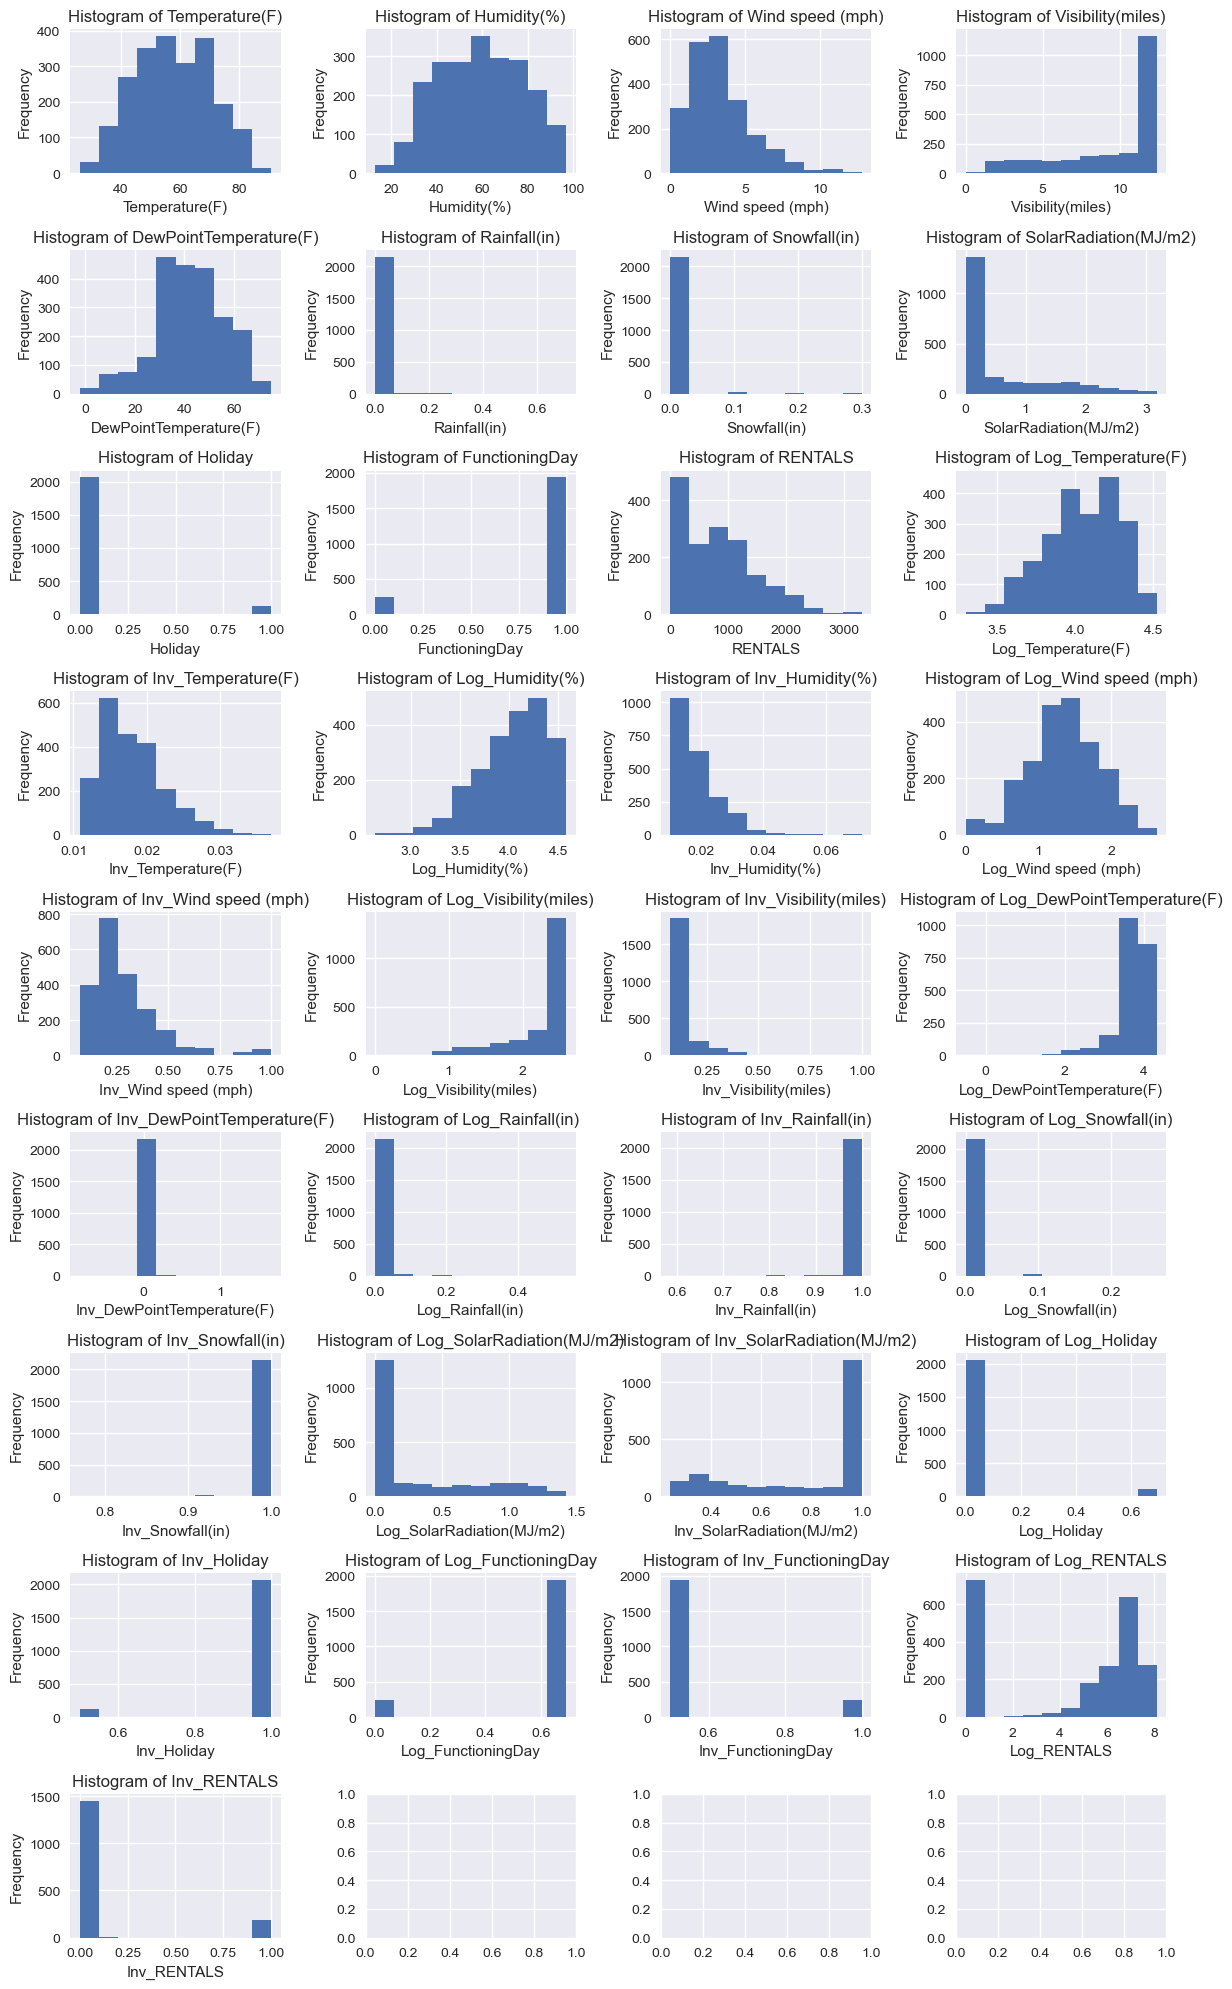

In [14]:
# check histograms of all numeric columns
numeric_columns = merged_df.select_dtypes(include='number').columns

ncols = 4
nrows = math.ceil(len(numeric_columns) / ncols)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*3, ncols*5))

k = 0
for i in range(nrows):
    for j in range(ncols):
        if not k < len(numeric_columns):
            break
        ax[i][j].hist(x = merged_df[numeric_columns[k]])
        ax[i][j].set_title(f'Histogram of {numeric_columns[k]}')
        ax[i][j].set_ylabel('Frequency')
        ax[i][j].set_xlabel(numeric_columns[k])
        k += 1

plt.tight_layout()
plt.show()

#### *Findings:*

- Most of the default continuous data have a good-looking distribution.
- We can see the variables that are skewed.

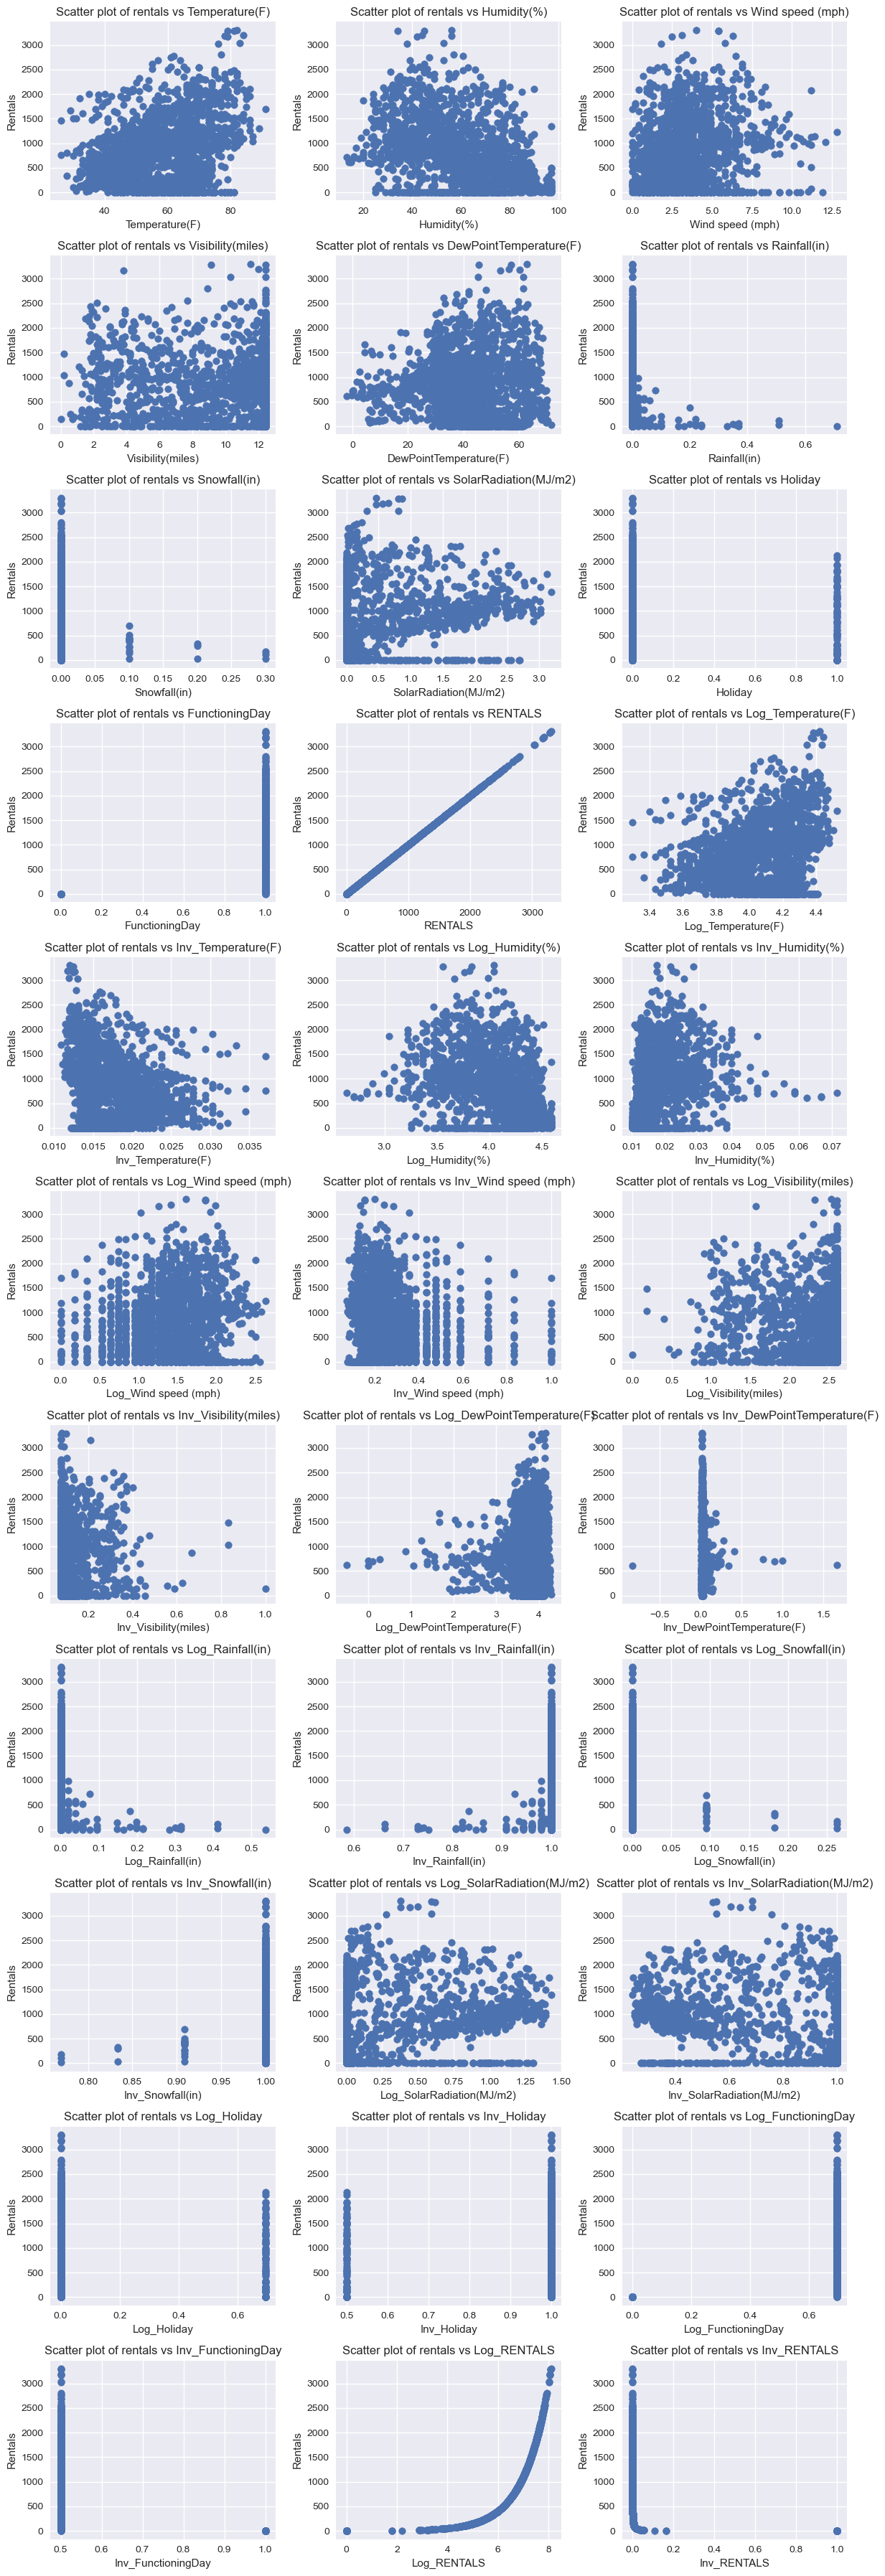

In [15]:
numeric_columns = merged_df.select_dtypes(include='number').columns

ncols = 3
nrows = math.ceil(len(numeric_columns) / ncols)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, ncols*12))

k = 0
for i in range(nrows):
    for j in range(ncols):
        if not k < len(numeric_columns):
            break
        ax[i][j].scatter(x = merged_df[numeric_columns[k]], y = merged_df[y_variable])
        ax[i][j].set_title(f'Scatter plot of rentals vs {numeric_columns[k]}')
        ax[i][j].set_ylabel('Rentals')
        ax[i][j].set_xlabel(numeric_columns[k])
        k += 1

plt.tight_layout()
plt.show()

#### *Finding:*

- ```RENTALS``` is always 0 when FunctioningDay is 0
- Solar radiation, temperature, and humidity has some linearity. If we can explain the outliers, we can create good correlations.
- There are less rentals when there is rain or snow.
- The outliers in many plots are days with zero rentals. We can ignore them to create a nicer correlation.

In [16]:
# check if there are days with zero rentals but functioning

merged_df[(merged_df[y_variable] == 0) & (merged_df['FunctioningDay'] == 1)].empty

True

In [17]:
# check if there are days with rentals but not functioning

merged_df[(merged_df[y_variable] == 1) & (merged_df['FunctioningDay'] == 0)].empty

True

#### *Finding:*

- Both sets are empty. We can separate non-zero rentals without worries.

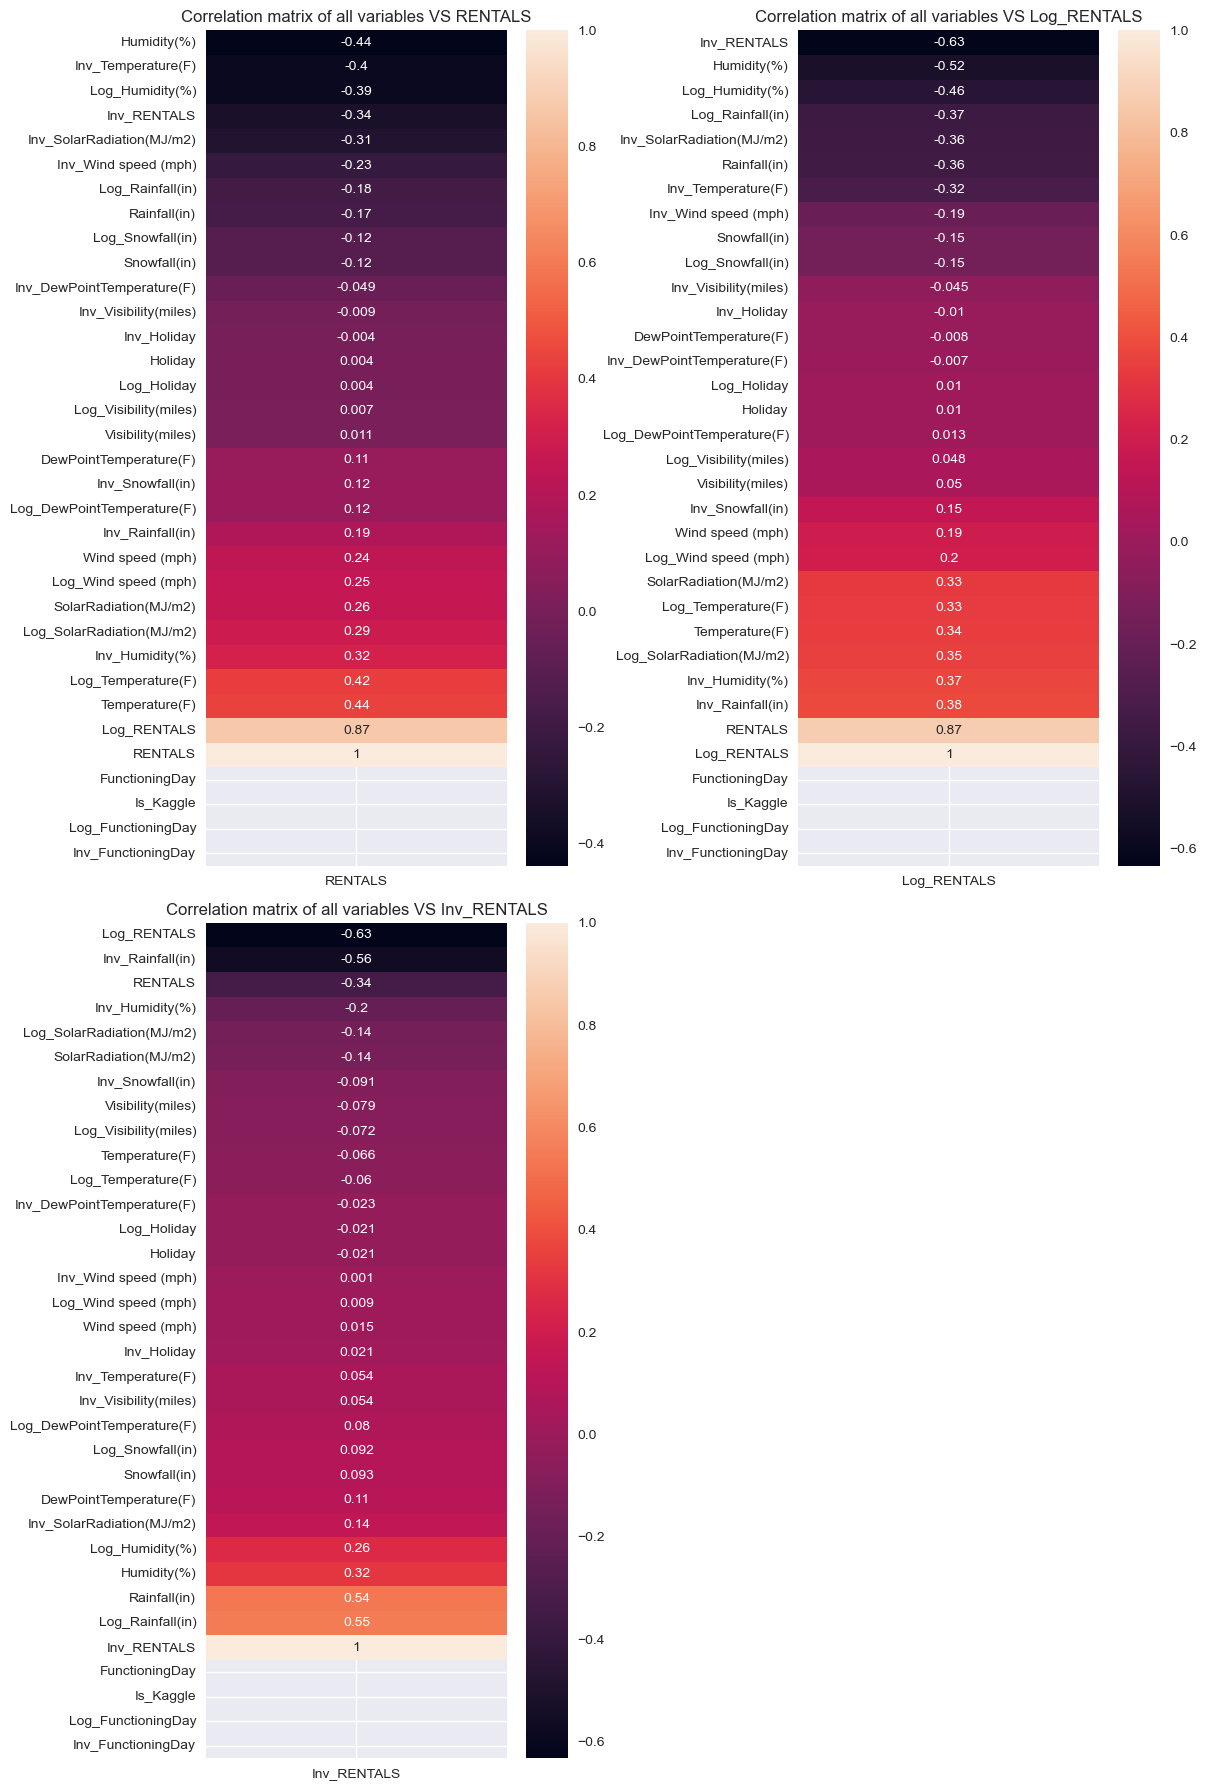

In [18]:
# Remove 0 and NA rentals
non_zero_rentals_merged_df = merged_df[(merged_df[y_variable] > 0) & ~(merged_df[y_variable].isna())]

# Redo correlation
# get sorted correlations of non-na data
corr = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[y_variable]].sort_values(y_variable)
corr_log = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[log_y_variable]].sort_values(log_y_variable)
corr_inv = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[inv_y_variable]].sort_values(inv_y_variable)

base_text = 'Correlation matrix of all variables VS'

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 18))

ax[0,0].set_title(f'{base_text} {y_variable}')
sns.heatmap(corr, annot=True, ax=ax[0,0])

ax[0,1].set_title(f'{base_text} {log_y_variable}')
sns.heatmap(corr_log, annot=True, ax=ax[0,1])

ax[1,0].set_title(f'{base_text} {inv_y_variable}')
sns.heatmap(corr_inv, annot=True, ax=ax[1,0])

ax[1,1].axis('off') # empty last axis

plt.tight_layout()
plt.show()

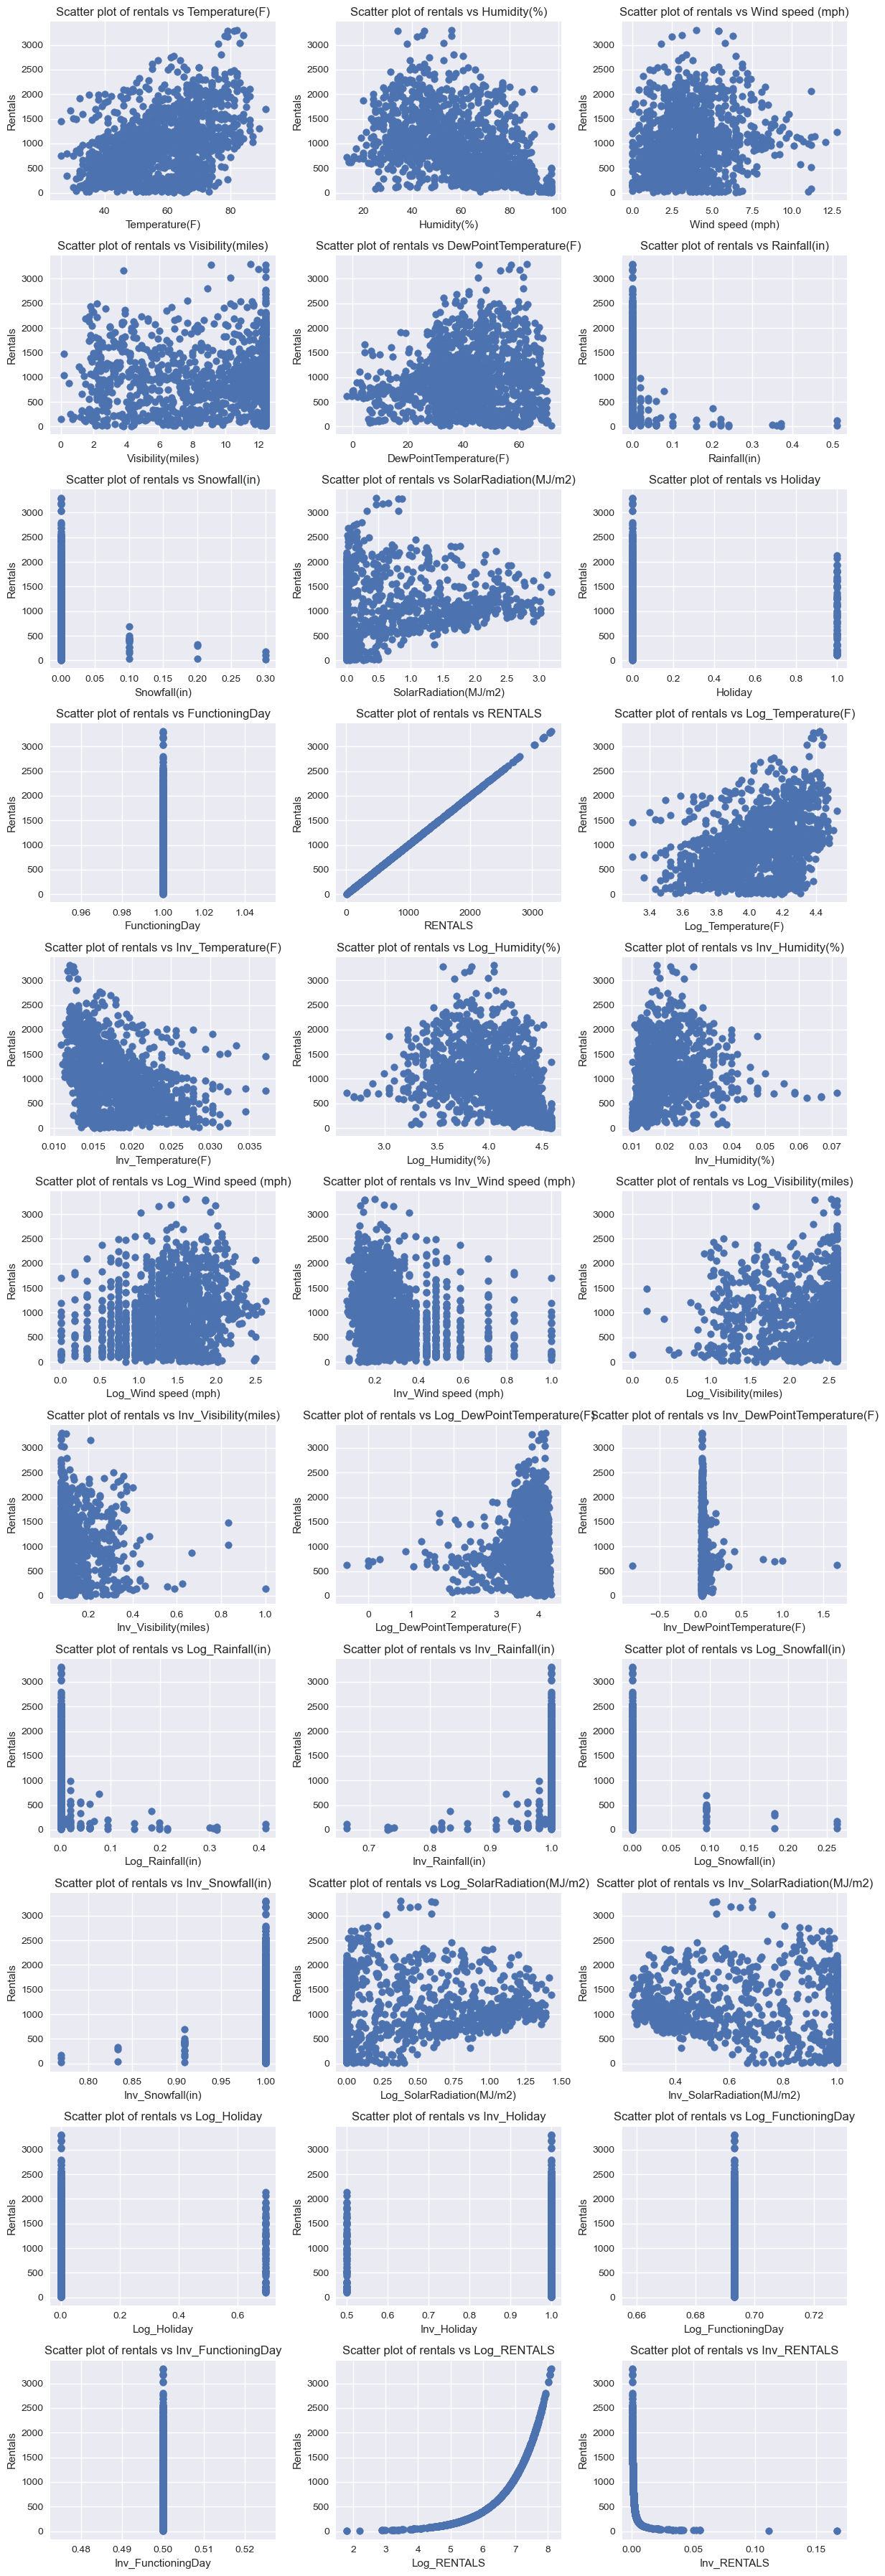

In [19]:
# Redo scatterplot
numeric_columns = non_zero_rentals_merged_df.select_dtypes(include='number').columns

ncols = 3
nrows = math.ceil(len(numeric_columns) / ncols)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, ncols*12))

k = 0
for i in range(nrows):
    for j in range(ncols):
        if not k < len(numeric_columns):
            break
        ax[i][j].scatter(x = non_zero_rentals_merged_df[numeric_columns[k]], y = non_zero_rentals_merged_df[y_variable])
        ax[i][j].set_title(f'Scatter plot of rentals vs {numeric_columns[k]}')
        ax[i][j].set_ylabel('Rentals')
        ax[i][j].set_xlabel(numeric_columns[k])
        k += 1

plt.tight_layout()
plt.show()

#### *Finding:*

- The scatter plots look more linear.
- There are correlation gains too.
- ```Inv_Rainfall``` and ```Log_Rainfall``` have ~0.5 correlation with rentals or a transformation of rentals.

#### Categorical Data Analysis

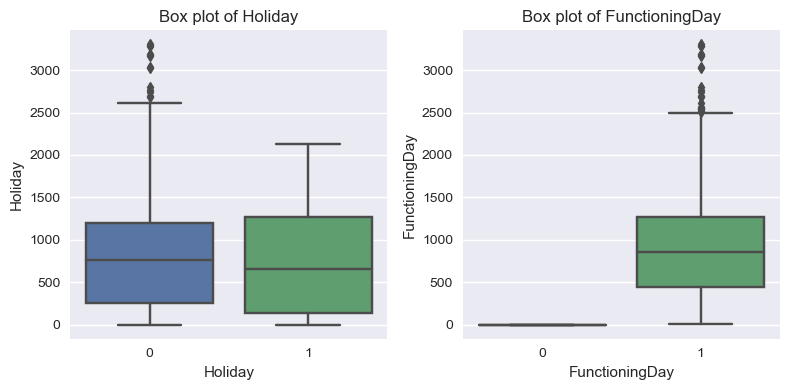

In [20]:
# check variations among categorical variables
categorical_columns = ['Holiday', 'FunctioningDay']

ncols = 2
nrows = math.ceil(len(categorical_columns) / ncols)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, ncols*2))

k = 0
for i in range(ncols):
    if not k < len(categorical_columns):
        break
    sns.boxplot(x=categorical_columns[k], y='RENTALS', data=merged_df, ax=ax[i])
    ax[i].set_title(f'Box plot of {categorical_columns[k]}')
    ax[i].set_ylabel(categorical_columns[k])
    k += 1

plt.tight_layout()
plt.show()

#### *Finding:*

- As confirmed earlier, there are no rentals when functioning day is 0.
- There are slightly more rentals on non-holidays with lots of high outliers.

### Feature Engineering

Now, we have enough information to create new features.

#### Feature Idea 1: Break datetime into components

The hour of the day could have a high impact on the rentals. People tend to rent bikes in the morning, midday, or early evening. We can separate the datetime component into individual components.

Note: there is a column called Real_Hour that captures the real hour because some DateHour values were in the 59th minute. Simply, taking the hour component would give the wrong hour. We keep both because they can be useful.

In [21]:
# break datetime into components
date_column = 'DateHour'

merged_df['Hour'] = merged_df[date_column].dt.hour
merged_df['Real_Hour'] = merged_df[date_column].dt.ceil('h').dt.hour # we use ceil because some data are recorded at the 59th minute

#### Feature Idea 2: Mean of rentals when there is rain or snow

There is some variance when the data points are grouped by rain and snow, as the scatter plot shows. We can capture both in one variable, then get a better feature by checking the rental mean in both groups. This creates a continuous-like variable because there is a consistent interval. From the scatter plot, it make sense that the means would be different because days without rain or snow have more rentals while days with rain or snow have far fewer and lower rentals.

In [22]:
merged_df['Is_Precipitation'] = (merged_df['Rainfall(in)'] + merged_df['Snowfall(in)'] != 0).astype(int)

rental_means_by_precipitation = merged_df.groupby('Is_Precipitation')['RENTALS'].mean()
merged_df['Rental_Mean_By_Precipitation'] = merged_df['Is_Precipitation'].map(rental_means_by_precipitation)

#### Feature Idea 3: Interaction variable between temperature and humidity

Temperature has a high positive correlation and humidity has a high negative correlation. We can get an interaction variable by dividing temperature with humidity. This should give us a higher correlation.

This also makes sense because a hot day with high humidity feels more uncomfortable than the same day with low humidity. This feature would guage how comfortable a particular hour feels.

In [23]:
merged_df['Temperature_Humidity_Interaction'] = merged_df['Temperature(F)'] / merged_df['Humidity(%)']

#### Feature Idea 4: Mean of rentals by real hour

Just like days with precipitation would have different means, different hour would have different means. Some hours are peak hours while others are not. This feature can give us a good continuous-like variable that explains the variance of according to different hours.

In [24]:
rental_means_by_real_hour = merged_df.groupby('Real_Hour')['RENTALS'].mean()
merged_df['Rental_Mean_By_Real_Hour'] = merged_df['Real_Hour'].map(rental_means_by_real_hour)

#### Feature Idea 5: Interaction variable between temperature, humidity, and the real hour rental mean

This feature combines the temperature, humidity, and hour rental mean to explain how the mean connects to how uncomfortable the temperature and humidity makes the day feel. This will help smoothen out the rental mean on a scatter plot to look more linear. The more linear the feature, the better.

In [25]:
merged_df['Temperature_Humidity_Real_Hour_Rental_Mean_Interaction'] = merged_df['Temperature(F)'] * \
    merged_df['Rental_Mean_By_Real_Hour'] / \
    merged_df['Humidity(%)']

#### Feature Idea 6: Sin function of hour and interaction variable between temperature, humidity, and sin function of hours

Rentals collected over hours are cyclical in nature. Like a stock charts, it fluctuates up and down. This cyclical pattern is similar to a sin (and cosine) pattern. Transforming hour with the sin function can help to bring out this cyclic pattern. Multiplying that with the temperature and humidity interaction may be valuable.

In [26]:
maximum_hour_value = 23

merged_df['Hour_Sin'] = np.sin(2 * np.pi * merged_df['Hour'] / maximum_hour_value)

merged_df['Temperature_Humidity_Hour_Sin_Interaction'] = merged_df['Hour_Sin'] * \
    merged_df['Temperature(F)'] / \
    merged_df['Humidity(%)']

#### Feature Idea 7: Mean grouped by holiday

Holidays also seem to explain a lot of the high rental values. There are few high rentals on holidays. Getting the mean by holiday status can help to explain some of the variance in our response variable.

In [27]:
holiday_means = merged_df.groupby('Holiday')['RENTALS'].mean()
merged_df['Mean_By_Holiday'] = merged_df['Holiday'].map(holiday_means)

#### Exploratory Data Analysis With New Features

Let's examine the scatter plots and correlations again.

First, let's apply our transformations to the new features.

In [28]:
# Apply transformations to new features
numeric_columns = merged_df.select_dtypes(include='number').columns

for column in numeric_columns:
    if column.startswith(LOG_PREFIX) or column.startswith(INV_PREFIX):
        pass
    else:
        merged_df[LOG_PREFIX + column] = merged_df[column].apply(lambda x: np.log1p(x) if x > -1 else 0)
        merged_df[INV_PREFIX + column] = merged_df[column].apply(lambda x: 1 / (x + 1))

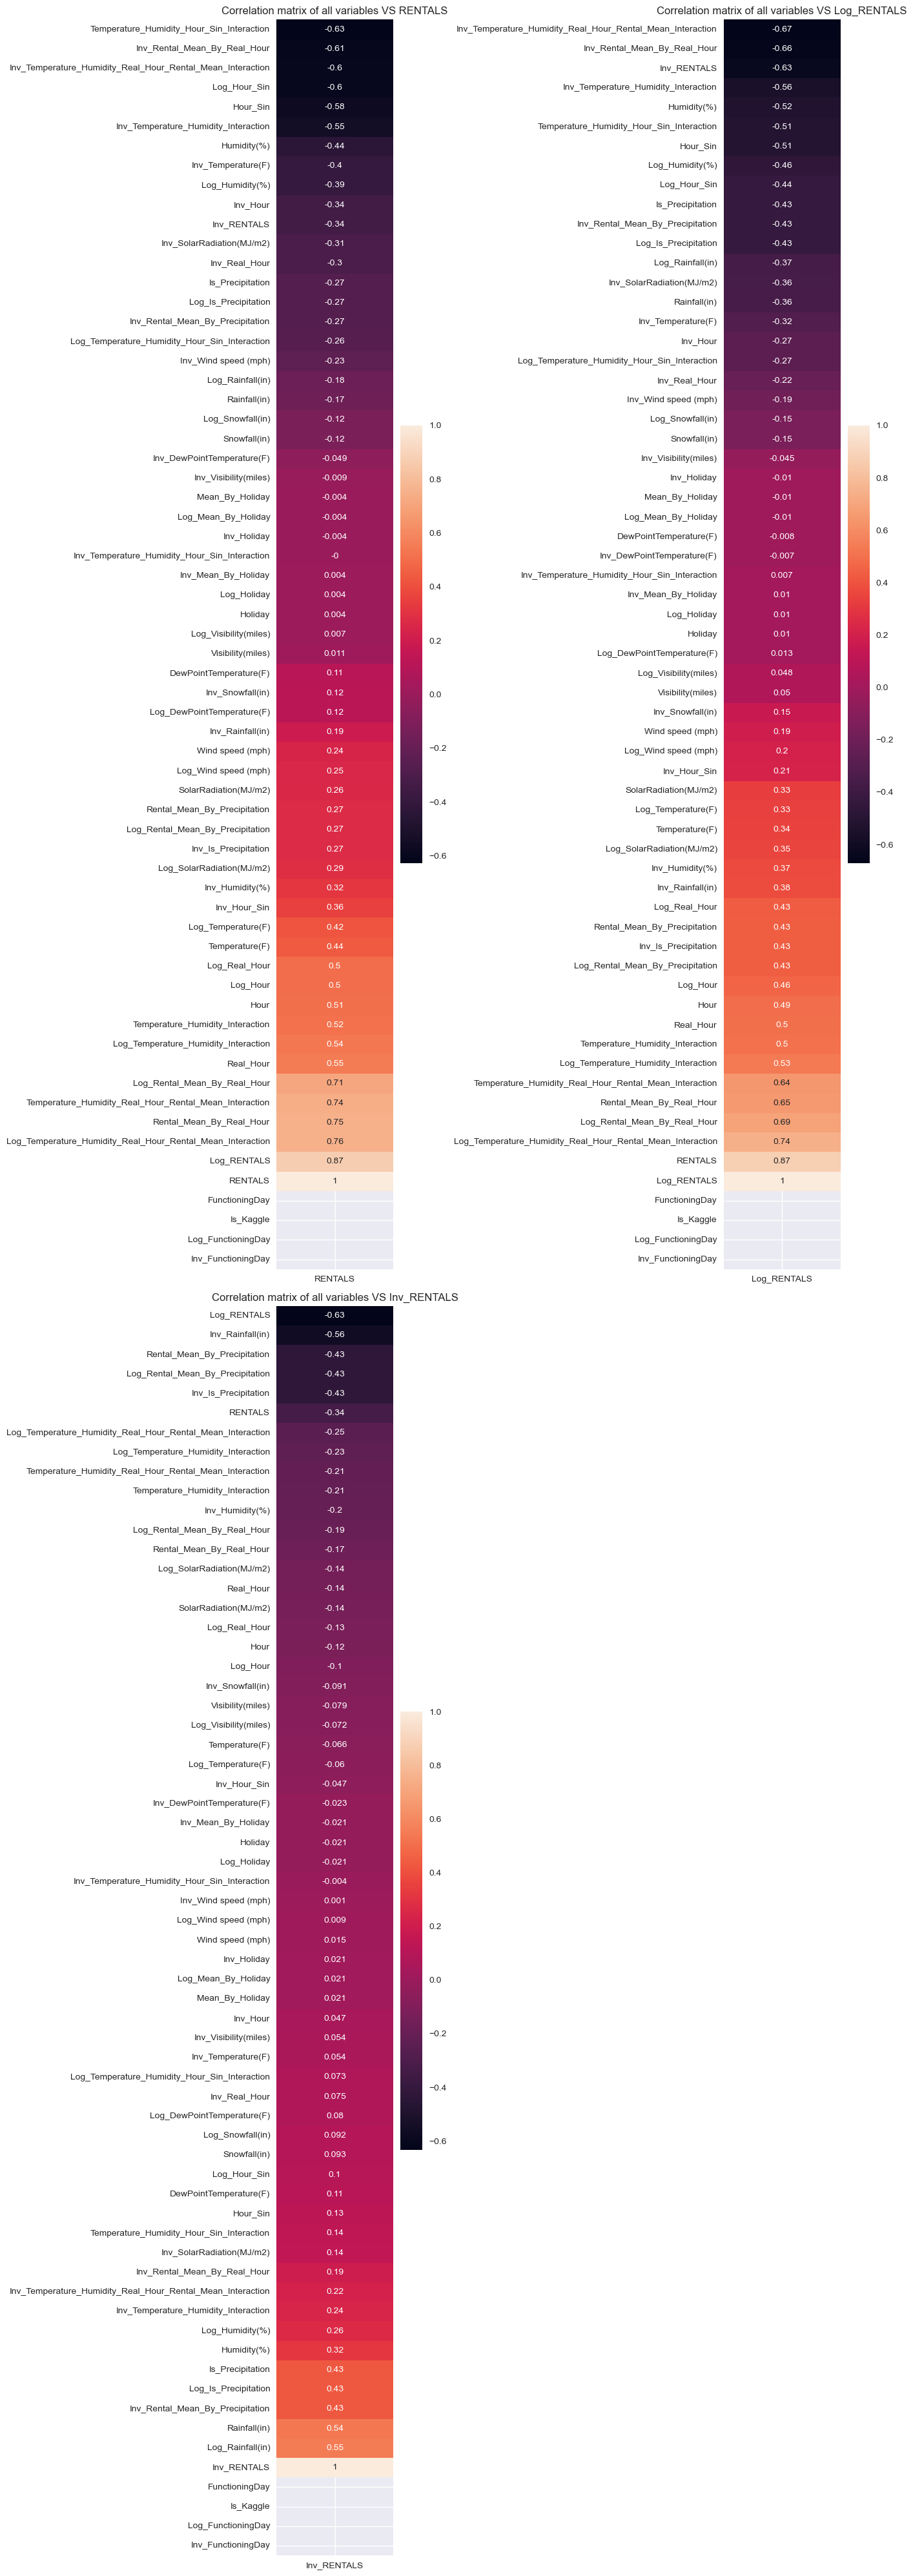

In [29]:
# check correlations again of new features

# Remove 0 and NA rentals
non_zero_rentals_merged_df = merged_df[(merged_df[y_variable] > 0) & ~(merged_df[y_variable].isna())]

# Redo correlation

# get sorted correlations of non-na data
corr = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[y_variable]].sort_values(y_variable)
corr_log = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[log_y_variable]].sort_values(log_y_variable)
corr_inv = non_zero_rentals_merged_df.corr(numeric_only = True).round(3)[[inv_y_variable]].sort_values(inv_y_variable)

base_text = 'Correlation matrix of all variables VS'

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 40))

ax[0,0].set_title(f'{base_text} {y_variable}')
sns.heatmap(corr, annot=True, ax=ax[0,0])

ax[0,1].set_title(f'{base_text} {log_y_variable}')
sns.heatmap(corr_log, annot=True, ax=ax[0,1])

ax[1,0].set_title(f'{base_text} {inv_y_variable}')
sns.heatmap(corr_inv, annot=True, ax=ax[1,0])

ax[1,1].axis('off') # empty last axis

plt.tight_layout()
plt.show()

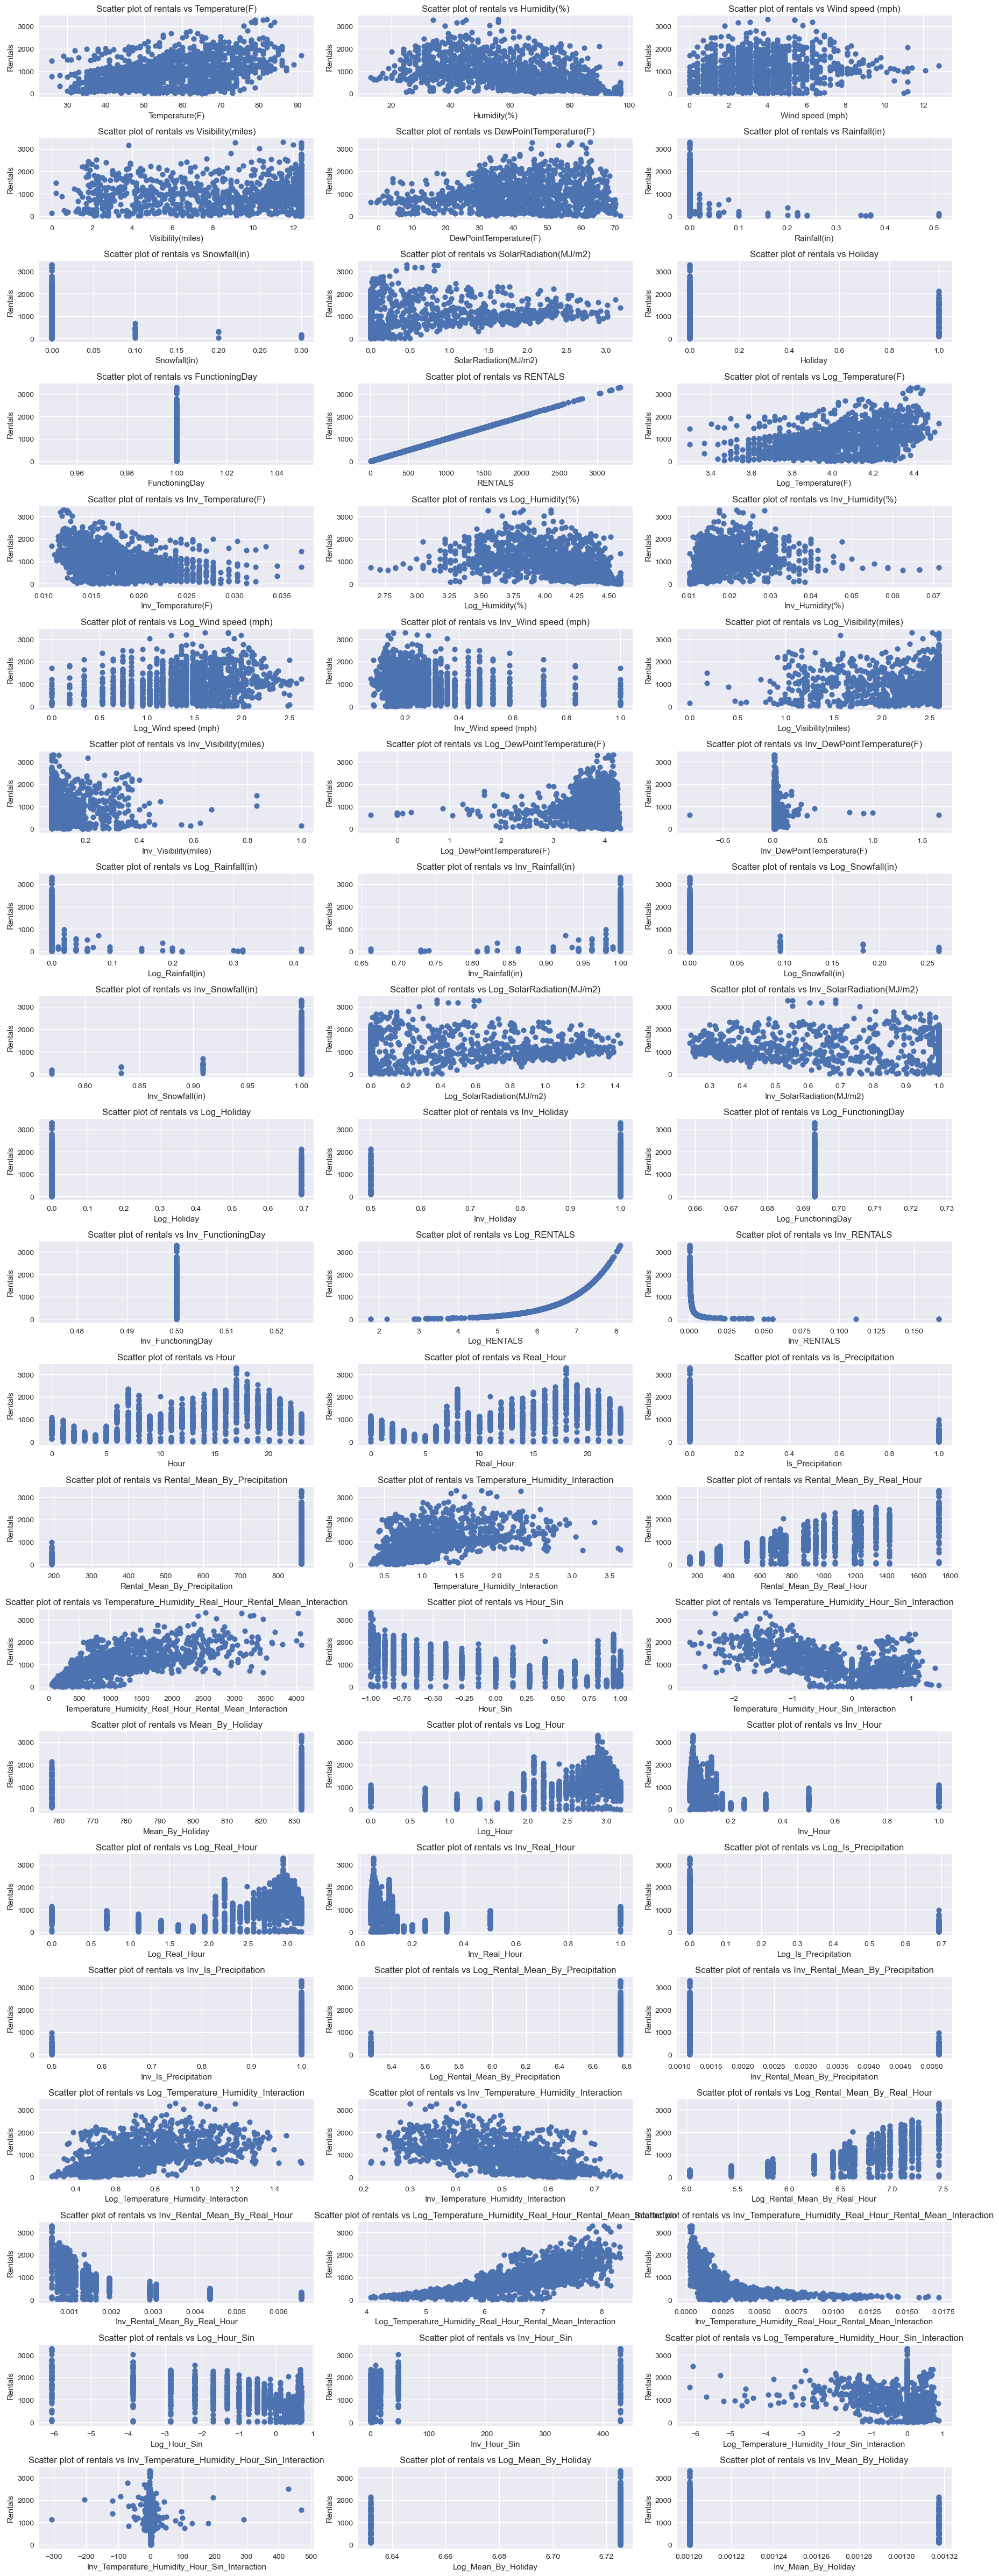

In [30]:
# Redo scatterplot
numeric_columns = non_zero_rentals_merged_df.select_dtypes(include='number').columns

ncols = 3
nrows = math.ceil(len(numeric_columns) / ncols)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*6, ncols*16))

k = 0
for i in range(nrows):
    for j in range(ncols):
        if not k < len(numeric_columns):
            break
        ax[i][j].scatter(x = non_zero_rentals_merged_df[numeric_columns[k]], y = non_zero_rentals_merged_df[y_variable])
        ax[i][j].set_title(f'Scatter plot of rentals vs {numeric_columns[k]}')
        ax[i][j].set_ylabel('Rentals')
        ax[i][j].set_xlabel(numeric_columns[k])
        k += 1

plt.tight_layout()
plt.show()

#### *Findings:*

- We can see very strong patterns in some of the new features and their transformations.
- These patterns will help our model explain rentals.
- Some transformations capture patterns our bare features cannot capture.
- For example, the Inv_Temperature_Humidity_Real_Hour_Rental_Mean, and real hour mean explains a lot of the high rental values. Cutting the bottom part would leave a very nice correlation
- These can be seen on others too.

### Standardization

In [31]:
# the scaler will be used for KNN and SGD regressors
numeric_columns = merged_df.select_dtypes(include='number').columns

scaler = StandardScaler()
scaler.fit(merged_df[numeric_columns])

StandardScaler()

## Data Partitioning

In [32]:
# All explanatory variables
X_features = [
    'Hour',
    'Temperature_Humidity_Real_Hour_Rental_Mean_Interaction',
    'Rental_Mean_By_Real_Hour',
    'Temperature(F)',
    'Rental_Mean_By_Precipitation',
    'Temperature_Humidity_Interaction',
    'Humidity(%)',
    'Log_Humidity(%)',
    'Inv_Humidity(%)',
    'Holiday',
    'Mean_By_Holiday',
    'SolarRadiation(MJ/m2)',
    'Inv_SolarRadiation(MJ/m2)',
    'FunctioningDay',
    'Rainfall(in)',
    'Visibility(miles)',
    'Inv_Temperature(F)',
    'Log_SolarRadiation(MJ/m2)',
    'Hour_Sin',
    'Temperature_Humidity_Hour_Sin_Interaction',
    'Inv_Temperature_Humidity_Real_Hour_Rental_Mean_Interaction',
    'Inv_Temperature_Humidity_Interaction'
]
# explanatory variables were built with lots of trial and error
# optimizing for r-square while minimizing overfitting

#### Findings:

- While the variables are a lot for some models, we can detect overfitting with train-test gap analysis so no need to worry

In [33]:
train_df = merged_df[merged_df['Is_Kaggle']].drop(
    labels='Is_Kaggle', axis=1) # get train data
train_df.head()

ID                DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2)  Holiday  FunctioningDay  RENTALS  Log_Temperature(F)  Inv_Temperature(F)  Log_Humidity(%)  Inv_Humidity(%)  Log_Wind speed (mph)  Inv_Wind speed (mph)  Log_Visibility(miles)  Inv_Visibility(miles)  Log_DewPointTemperature(F)  Inv_DewPointTemperature(F)  Log_Rainfall(in)  Inv_Rainfall(in)  Log_Snowfall(in)  Inv_Snowfall(in)  Log_SolarRadiation(MJ/m2)  Inv_SolarRadiation(MJ/m2)  Log_Holiday  Inv_Holiday  Log_FunctioningDay  Inv_FunctioningDay  Log_RENTALS  Inv_RENTALS  Hour  Real_Hour  Is_Precipitation  Rental_Mean_By_Precipitation  Temperature_Humidity_Interaction  Rental_Mean_By_Real_Hour  Temperature_Humidity_Real_Hour_Rental_Mean_Interaction  Hour_Sin  Temperature_Humidity_Hour_Sin_Interaction  Mean_By_Holiday  Log_Hour  Inv_Hour  Log_Real_Hour  Inv_Real_Hour  Log_Is_Precipitation  Inv_Is_Precipitation  \
0  mb_1039 2023-10-14 05:59:54.810            52.0         81.0               0.4           2.900000                    46.4           0.0           0.0                   0.00        0               1    519.0            3.970292            0.018868         4.406719         0.012195              0.336472              0.714286               1.360977               0.256410                    3.858622                    0.021097               0.0               1.0               0.0               1.0                   0.000000                   1.000000          0.0          1.0            0.693147                 0.5     6.253829     0.001923     5          6                 0                    862.400257                          0.641975                325.275362                                         208.818751       0.979084                                   0.628548       832.040593  1.791759  0.166667       1.945910       0.142857                   0.0                   1.0   
1  mb_1330 2023-10-26 08:59:53.355            51.0         53.0               2.2           8.966667                    35.2           0.0           0.0                   1.01        0               1   1251.0            3.951244            0.019231         3.988984         0.018519              1.163151              0.312500               2.299246               0.100334                    3.589059                    0.027624               0.0               1.0               0.0               1.0                   0.698135                   0.497512          0.0          1.0            0.693147                 0.5     7.132498     0.000799     8          9                 0                    862.400257                          0.962264                758.313433                                         729.697832       0.816970                                   0.786141       832.040593  2.197225  0.111111       2.302585       0.100000                   0.0                   1.0   
2   mb_551 2023-09-23 21:59:57.250            56.0         49.0               2.5           3.400000                    38.8           0.0           0.0                   0.00        0               1   1685.0            4.043051            0.017544         3.912023         0.020000              1.252763              0.285714               1.481605               0.227273                    3.683867                    0.025126               0.0               1.0               0.0               1.0                   0.000000                   1.000000          0.0          1.0            0.693147                 0.5     7.430114     0.000593    21         22                 0                    862.400257                          1.142857               1002.428571                                        1145.632653      -0.519584                                  -0.593810       832.040593  3.091042  0.045455       3.135494       0.043478                   0.0                   1.0   
3  mb_2103 2023-12-19 14

In [34]:
test_df = merged_df[np.logical_not(merged_df['Is_Kaggle'])].drop(
    labels='Is_Kaggle', axis=1) # get test data
test_df.head()

ID                DateHour  Temperature(F)  Humidity(%)  Wind speed (mph)  Visibility(miles)  DewPointTemperature(F)  Rainfall(in)  Snowfall(in)  SolarRadiation(MJ/m2)  Holiday  FunctioningDay  RENTALS  Log_Temperature(F)  Inv_Temperature(F)  Log_Humidity(%)  Inv_Humidity(%)  Log_Wind speed (mph)  Inv_Wind speed (mph)  Log_Visibility(miles)  Inv_Visibility(miles)  Log_DewPointTemperature(F)  Inv_DewPointTemperature(F)  Log_Rainfall(in)  Inv_Rainfall(in)  Log_Snowfall(in)  Inv_Snowfall(in)  Log_SolarRadiation(MJ/m2)  Inv_SolarRadiation(MJ/m2)  Log_Holiday  Inv_Holiday  Log_FunctioningDay  Inv_FunctioningDay  Log_RENTALS  Inv_RENTALS  Hour  Real_Hour  Is_Precipitation  Rental_Mean_By_Precipitation  Temperature_Humidity_Interaction  Rental_Mean_By_Real_Hour  Temperature_Humidity_Real_Hour_Rental_Mean_Interaction  Hour_Sin  Temperature_Humidity_Hour_Sin_Interaction  Mean_By_Holiday  Log_Hour  Inv_Hour  Log_Real_Hour  Inv_Real_Hour  Log_Is_Precipitation  Inv_Is_Precipitation  \
1638  mb_382 2023-09-16 20:59:58.095            73.0         70.0               5.6                9.8                    65.7           0.0           0.0                   0.00        0               1      NaN            4.304065            0.013514         4.262680         0.014085              1.887070              0.151515               2.379546               0.092593                    4.200205                    0.014993               0.0               1.0               0.0               1.0                   0.000000                   1.000000     0.000000          1.0            0.693147                 0.5          0.0          NaN    20         21                 0                    862.400257                          1.042857               1073.119403                                        1119.110235      -0.730836                                  -0.762158       832.040593  3.044522  0.047619       3.091042       0.045455                   0.0                   1.0   
1639  mb_547 2023-09-23 17:59:57.270            63.0         39.0               2.2                2.5                    39.0           0.0           0.0                   0.21        0               1      NaN            4.158883            0.015625         3.688879         0.025000              1.163151              0.312500               1.252763               0.285714                    3.688879                    0.025000               0.0               1.0               0.0               1.0                   0.190620                   0.826446     0.000000          1.0            0.693147                 0.5          0.0          NaN    17         18                 0                    862.400257                          1.615385               1730.743243                                        2795.816008      -0.997669                                  -1.611619       832.040593  2.890372  0.055556       2.944439       0.052632                   0.0                   1.0   
1640  mb_578 2023-09-25 00:59:57.115            69.0         54.0               0.2                8.6                    48.6           0.0           0.0                   0.00        0               1      NaN            4.248495            0.014286         4.007333         0.018182              0.182322              0.833333               2.261763               0.104167                    3.903991                    0.020161               0.0               1.0               0.0               1.0                   0.000000                   1.000000     0.000000          1.0            0.693147                 0.5          0.0          NaN     0          1                 0                    862.400257                          1.277778                512.353846                                         654.674359       0.000000                                   0.000000       832.040593  0.000000  1.000000       0.693147       0.500000                   0.0                   1.0   
1641  mb_187 2023-

In [35]:
# prepping data for train-test split
y_data = train_df[y_variable]


# removing non-numeric columns and missing values
X_data = train_df[X_features].copy().select_dtypes(include=np.number).dropna(axis=1)

# storing remaining x_features after the step above
x_features = list(X_data.columns)

# train-test split (to validate the model)
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {train_df.shape[0]}
Features  (Columns): {train_df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {X_train.shape[0]}
Features  (Columns): {X_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {X_test.shape[0]}
Features  (Columns): {X_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 1638
Features  (Columns): 65


Training Data (X-side)
----------------------
Observations (Rows): 1228
Features  (Columns): 22


Training Data (y-side)
----------------------
Feature Name:        RENTALS
Observations (Rows): 1228


Testing Data (X-side)
---------------------
Observations (Rows): 410
Features  (Columns): 22


Testing Data (y-side)
---------------------
Feature Name:        RENTALS
Observations (Rows): 410


## Candidate Modeling

In [36]:
OLS = 'OLS Linear Regression'
LASSO = 'Lasso Regression'
RIDGE = 'Ridge Regression'
ELASTIC_NET = 'Elastic Net Regression'
KNN = 'K-Nearest Neighbor'
DECISION_TREE = 'Decision Tree'

model_types = {
    OLS: LinearRegression,
    LASSO: Lasso,
    RIDGE: Ridge,
    ELASTIC_NET: SGDRegressor,
    KNN: KNeighborsRegressor,
    DECISION_TREE: DecisionTreeRegressor
}

### OLS Linear Regression

In [37]:
model_name = OLS
model = model_types[model_name]()

# FITTING to the training data
model_fit = model.fit(X_train, y_train)


# PREDICTING on new data
model_pred = model.predict(X_test)


# SCORING the results
model_train_score = model.score(X_train, y_train).round(4)
model_test_score  = model.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     OLS Linear Regression
Train_Score:    0.7565
Test_Score:     0.7472
Train-Test Gap: 0.0093



#### *Findings:*

- OLS performs well and explains about 75% of the variations in data.
- Train test gap is very small.

### Lasso Regression

In [38]:
model_name = LASSO
model = model_types[model_name]()

# FITTING to the training data
model_fit = model.fit(X_train, y_train)


# PREDICTING on new data
model_pred = model.predict(X_test)


# SCORING the results
model_train_score = model.score(X_train, y_train).round(4)
model_test_score  = model.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     Lasso Regression
Train_Score:    0.753
Test_Score:     0.7375
Train-Test Gap: 0.0155



#### Findings:

- Lasso has a lower score but higher train test gap despite the penalty.

### Ridge Regression

In [39]:
model_name = RIDGE
model = model_types[model_name]()

# FITTING to the training data
model_fit = model.fit(X_train, y_train)


# PREDICTING on new data
model_pred = model.predict(X_test)


# SCORING the results
model_train_score = model.score(X_train, y_train).round(4)
model_test_score  = model.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     Ridge Regression
Train_Score:    0.7533
Test_Score:     0.7372
Train-Test Gap: 0.0161



#### Findings:

- Ridge has a lower score than OLS but higher train test gap despite the penalty, also.

### Elastic Net Regression

In [40]:
model_name = ELASTIC_NET
model = model_types[model_name]()

# create pipeline for scaling and doing regression
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

# FITTING to the training data
model_fit = pipeline.fit(X_train, y_train)


# PREDICTING on new data
model_pred = pipeline.predict(X_test)


# SCORING the results
model_train_score = pipeline.score(X_train, y_train).round(4)
model_test_score  = pipeline.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     Elastic Net Regression
Train_Score:    0.7525
Test_Score:     0.7364
Train-Test Gap: 0.0161



#### Findings:

- Elastic Net has the lowest score of all linear regressors.

### K-Nearest Neighbors

In [41]:
model_name = KNN
model = model_types[model_name]()

# create pipeline for scaling and doing regression
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

# FITTING to the training data
model_fit = pipeline.fit(X_train, y_train)


# PREDICTING on new data
model_pred = pipeline.predict(X_test)


# SCORING the results
model_train_score = pipeline.score(X_train, y_train).round(4)
model_test_score  = pipeline.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     K-Nearest Neighbor
Train_Score:    0.8903
Test_Score:     0.8188
Train-Test Gap: 0.0715



#### Findings:

- KNN has a really high score but high train-test gap.
- Ideally, train-test gap should be within 0.05 but 0.07 is good enough compared to the other models because of the high r-square gains.
- Predicting the rentals of bikes is not crucial enough to worry about 0.07 train test gap.
- This is where other metrics involving false positives and false negatives can apply but that is out of scope for this assignment.

### Decision Tree

In [42]:
model_name = DECISION_TREE
model = model_types[model_name]()

# FITTING to the training data
model_fit = model.fit(X_train, y_train)


# PREDICTING on new data
model_pred = model.predict(X_test)


# SCORING the results
model_train_score = model.score(X_train, y_train).round(4)
model_test_score  = model.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     Decision Tree
Train_Score:    1.0
Test_Score:     0.6789
Train-Test Gap: 0.3211



#### Findings:

- Decision tree has the worst metric but might explain our model.
- Unforunately, plotting and explaining the tree would be too time-consuming as this is not the good model of choice.

## Hyper Parameter Tuning

The 3 best models were:
- KNN
- OLS
- Ridge

Let's perform hyper parameter tuning to improve their scores.

In [43]:
model_name = RIDGE
model = model_types[model_name]()

param_grid = {
    'alpha': np.logspace(-4, 4, 20),
}

random_search = GridSearchCV(model, param_grid, 
                                cv=5, scoring='r2')

random_search.fit(X_train, y_train)

print(f'''Best parameters for {model_name}:
{random_search.best_params_}

Best score (R^2) for {model_name}:
{random_search.best_score_}
''')

Best parameters for Ridge Regression:
{'alpha': 0.615848211066026}

Best score (R^2) for Ridge Regression:
0.7400922754163571



#### *Findings:*

- OLS is one of the best but has no hyper parameters so we cannot perform tuning.
- Ridge gained slightly from tuning but not too much. This shows that the top gains are in feature engineering.

## Final Model

Here, I perform hyperparameter tuning for my selected model before building it with the best parameter values. I improved performance by handling non-functioning days with a simple algorithm.

In [44]:
model_name = KNN
model = model_types[model_name]()

pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

param_grid = {
    'model__n_neighbors': np.arange(1, 12),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
}

random_search = GridSearchCV(pipeline, param_grid, 
                                cv=5, scoring='r2')

random_search.fit(X_train, y_train)

print(f'''Best parameters for {model_name}:
{random_search.best_params_}

Best score (R^2) for {model_name}:
{random_search.best_score_}
''')

Best parameters for K-Nearest Neighbor:
{'model__metric': 'euclidean', 'model__n_neighbors': 7, 'model__weights': 'distance'}

Best score (R^2) for K-Nearest Neighbor:
0.8217260679130998



In [45]:
# use the tuned parameters
for param_name in random_search.best_params_.keys():
    setattr(pipeline.named_steps[param_name.split("__")[0]], param_name.split("__")[1], random_search.best_params_[param_name])


# FITTING to the training data
model_fit = pipeline.fit(X_train, y_train)


# PREDICTING on new data
model_predictions = pipeline.predict(X_test)


# SCORING the results
model_train_score = pipeline.score(X_train, y_train).round(4)
model_test_score  = pipeline.score(X_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name} (tuned)
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     K-Nearest Neighbor (tuned)
Train_Score:    1.0
Test_Score:     0.8333
Train-Test Gap: 0.1667



#### *Findings:*

- The tuned version gives a very large train test gap.
- This was consistent with every tuned model before this.
- Upon double checking, the tuned version gives the same output with the untuned version but seems very overfit.
- As the assignment requires we apply hyper parameter tuning, I selected this tuned model.
- It still has the highest test scores among every other model, and the consequences of error for wrongly predicitng bike rentals is not too critical.


### Residual Analysis

In [46]:
## Residual Analysis ##

# organizing residuals
model_residuals = {
    "True": y_test,
    "Predicted": model_pred
}


# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)

residuals = model_resid_df['True'] - model_resid_df['Predicted']

# checking results
model_resid_df.head(n = 5)

True  Predicted
475   908.0      618.0
573   131.0       46.0
80   1208.0     1215.0
202   291.0      496.0
52   1433.0     1080.0

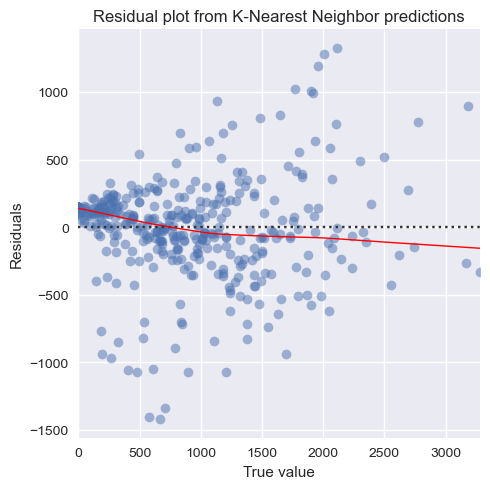

In [47]:
# plot residuals
fig = plt.figure(figsize=(5, 5))
sns.residplot(x='True', y=residuals, data=model_residuals, lowess=True, 
              scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1})
plt.title(f'Residual plot from {model_name} predictions')
plt.xlabel('True value')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

#### *Finding:*

- From the top right, we can see that the model doesn't explain high values very well. There are improvements to be made because we are under predicting them. We can search the scatter plots to try and explain high rental values.
- Holiday seems to have a lot of the high rentals so it can explain some. (Added)
- Residuals look more uniformly distributed.
- Our model is good for now.

## Preparing Submission File

In [48]:
# refit model to entire data frame for better accuracy on real data set
model_fit = pipeline.fit(X_data, y_data)

In [49]:
# x-data
X_data_kaggle = test_df[x_features].copy()


# y-data
y_data_kaggle = test_df[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions = pipeline.predict(X_data_kaggle)

In [50]:
## Kaggle Submission File ##

# organizing predictions
model_predictions = {y_variable : kaggle_predictions}

In [51]:
test_df[y_variable] = model_predictions[y_variable] # any functioning day with non-zero and any with 0?
test_df[(test_df[y_variable] != 0) & (test_df['FunctioningDay'] == 0)][['FunctioningDay', y_variable]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1803 to 2154
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FunctioningDay  6 non-null      int64  
 1   RENTALS         6 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 144.0 bytes


#### *Findings:*

- Entries exists, so the model missed some zero predictions. We can use a simple algorithm for quick accuracy gains.

In [52]:
# replace zeros with zero
test_df.loc[test_df['FunctioningDay'] == 0, y_variable] = 0

In [53]:
# converting predictions into df
model_pred_df = pd.DataFrame(data  = test_df[y_variable].values,
                             columns = [y_variable],
                             index = test_df['ID'])

In [54]:
#!######################!#
#!# name the .csv file #!#
#!######################!#

# name your model
model_pred_df.to_csv(path_or_buf = "./result.csv")

print(int(random.random() * 10**32))
model_pred_df.head(n=10)

62328567922462332314263106879488


RENTALS
ID                  
mb_382   1569.919241
mb_547   2392.327649
mb_578    648.613566
mb_187   1635.797865
mb_227    954.417305
mb_476   2028.547878
mb_395   1217.164570
mb_520   1639.760879
mb_1156   359.877242
mb_2121  1336.846192

# References

- OpenAI. (2024). ChatGPT interaction [Personal in-depth research].

Note: I didn't write code with ChatGPT. I only used ChatGPT to research statistics and data science concepts I didn't understand from class.